<p style="align: center;"><img align=center src="https://mailfit.com/wp-content/uploads/2019/11/lego-5.png"  width=900></p>
<h1 style="text-align: center;"><b>«Домашняя работа» - Ускорение тестирования</b></h3>


## Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
import scipy

from scipy import stats

warnings.filterwarnings('ignore')
sns.set_context("paper")

## Импорт данных

In [17]:
data_path = "https://raw.githubusercontent.com/a-milenkin/Datasetes_for_Piplines/main/SkillBox/ab_speedup.csv"
data = pd.read_csv(data_path, index_col=0)
print("Размеры датасета", data.shape)
data.head(6)

Размеры датасета (50000, 2)


,group,metrica
strata,,
11,history,42.631346
6,history,14.844453
4,history,2.362768
37,history,79.494017
18,history,-22.627788
34,history,28.679378


<div class="alert alert-info">
<b>Про Датасет</b>
    
Датасет представляет собой результаты некоторого А/B-Теста. 

* `strata` - Некоторая информация по страту (группа), к которой относится пользователь. 
* `group` - Группа эксперимента - тестовая, контрольная или прошлая история. 
* `metrica` - Целивая метрика
    
</div>

<div class="alert alert-info">

<b>Задание:</b>    
    
Найти различие между группами, увеличив чувствительность тестов тремя способами поочередно:
* Бутстрап
* Стратификация
* CUPED
    
Вспомогательная статья Валерия Бабушкина про стратификацию и CUPED:

* habr.com/ru/company/yandex/blog/497804/

Начнём с просмотра групп и построим график.

In [3]:
data.group.unique()

array(['history', 'B', 'A'], dtype=object)

In [18]:
a = data[data["group"] == "A"]["metrica"]
b = data[data["group"] == "B"]["metrica"]
history = data[data["group"] == "history"]["metrica"]

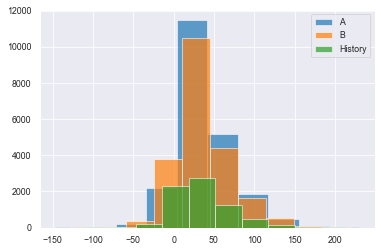

In [11]:
plt.hist(a, alpha=0.7, label="A")
plt.hist(b, alpha=0.7, label="B")
plt.hist(history, alpha=0.7, label="History")
plt.legend()
plt.show()

Судя по графику, группы различны, причём значения группы А больше значений группы B и обе группы больше исторических значений. Убедимся в этом, посчитав статистику.

#### Бутстрап

In [6]:
n_iterations = 1000

bootstrap_results_a = []
bootstrap_results_b = []
bootstrap_results_history = []

for _ in range(n_iterations):
      bootstrap_sample_a = np.random.choice(a, size=len(a), replace=True)
      bootstrap_results_a.append(np.mean(bootstrap_sample_a))

      bootstrap_sample_b = np.random.choice(b, size=len(b), replace=True)
      bootstrap_results_b.append(np.mean(bootstrap_sample_b))

      bootstrap_sample_history = np.random.choice(history, size=len(history), replace=True)
      bootstrap_results_history.append(np.mean(bootstrap_sample_history))

st, p_value = stats.ttest_ind(bootstrap_results_a, bootstrap_results_b, equal_var=False)
st_a_history, p_value_a_history = stats.ttest_ind(bootstrap_results_a, bootstrap_results_history, equal_var=False)
st_b_history, p_value_b_history = stats.ttest_ind(bootstrap_results_b, bootstrap_results_history, equal_var=False)

print('Сравнение групп A и B: \nstatistic = {}, p-value = {}'.format(st, p_value))
print('Сравнение групп A и history: \nstatistic = {}, p-value = {}'.format(p_value_a_history, st_a_history))
print('Сравнение групп B и history: \nstatistic = {}, p-value = {}'.format(p_value_b_history, st_b_history))

Сравнение групп A и B: 
statistic = 78.03572053435778, p-value = 0.0
Сравнение групп A и history: 
statistic = 2.2912449506487814e-97, p-value = 22.474711985435924
Сравнение групп B и history: 
statistic = 4.023926008560423e-177, p-value = -32.37879619458618


Результат бутстрапа также говорит, что все группы между собой статистически значимо различны (p-value равно 0 и близко к нулю).

#### Стратификация

In [21]:
data = data.reset_index(drop=False)
strata_unique = data.strata.nunique()
strata_unique

50

In [22]:
data_strata = data.groupby([data.index, 'group']).mean()
data_strata.head(6)

,,strata,metrica
,group,,
0,history,11.0,42.631346
1,history,6.0,14.844453
2,history,4.0,2.362768
3,history,37.0,79.494017
4,history,18.0,-22.627788
5,history,34.0,28.679378


Для начала посчитаем тест Манна-Уитни:

In [24]:
a = []
b = []
history = []
for _ in range(strata_unique):
      a = data[(data['group'] == 'A')]['metrica']
      b = data[(data['group'] == 'B')]['metrica']
      history = data[(data['group'] == 'history')]['metrica']

stats.mannwhitneyu(a, b, alternative='greater')

MannwhitneyuResult(statistic=232466032.0, pvalue=0.012365138100454288)

Отлично, группа A статистически больше группы B. Проведём стратификацию:

In [28]:
a_test = []
for _ in range(1000):
      a_test.append(data.sample(frac=1, replace=True).groupby([data.index, 'group']).mean())

result = pd.concat(a_test).reset_index()
stats.ttest_ind(result[result.group == 'A'].metrica, result[result.group == 'B'].metrica, alternative='greater')

Ttest_indResult(statistic=78.63098238350548, pvalue=0.0)

Успех. T-тест подтвердил наши выводы. Группы А и В различны статистически значимо, и в группе А значения больше.

#### CUPED

In [29]:
data_strata = data_strata.reset_index()
data_strata.head(6)

,level_0,group,strata,metrica
0,0,history,11.0,42.631346
1,1,history,6.0,14.844453
2,2,history,4.0,2.362768
3,3,history,37.0,79.494017
4,4,history,18.0,-22.627788
5,5,history,34.0,28.679378


In [31]:
data_cuped = pd.DataFrame()
data_cuped['strata'] = [_ for _ in range(50)]

data_cuped['a'] = data_strata[data_strata['group'] == 'A'].groupby('strata')['metrica'].mean().values[:50]
data_cuped['b'] = data_strata[data_strata['group'] == 'B'].groupby('strata')['metrica'].mean().values[:50]
data_cuped['history'] = data_strata[data_strata['group'] == 'history'].groupby('strata')['metrica'].mean().values[:50]

data_cuped['theta_a'] = 0
data_cuped['theta_b'] = 0
data_cuped['cuped_a'] = 0
data_cuped['cuped_b'] = 0

data_cuped.head(5)

,strata,a,b,history,theta_a,theta_b,cuped_a,cuped_b
0,0,11.315632,11.179934,11.042309,0,0,0,0
1,1,11.986065,12.542707,11.870768,0,0,0,0
2,2,12.864792,13.179972,12.799640,0,0,0,0
3,3,14.174155,14.038061,14.257758,0,0,0,0
4,4,15.712583,15.744811,14.942943,0,0,0,0


In [35]:
var = data_cuped['history'].var()
mean_before = data_cuped['history'].mean()

for i in range(strata_unique):
      data_cuped.theta_a.iloc[i] = np.cov([data_cuped['a'].iloc[i], data_cuped['history'].iloc[i]]) / var
      data_cuped.theta_b.iloc[i] = np.cov([data_cuped['b'].iloc[i], data_cuped['history'].iloc[i]]) / var
      data_cuped.cuped_a.iloc[i] = data_cuped['a'].iloc[i] - (data_cuped['history'].iloc[i] - mean_before) \
                                   * data_cuped['theta_a'].iloc[i]
      data_cuped.cuped_b.iloc[i] = data_cuped['b'].iloc[i] - (data_cuped['history'].iloc[i] - mean_before) \
                                   * data_cuped['theta_b'].iloc[i]

data_cuped.head(6)

,strata,a,b,history,theta_a,theta_b,cuped_a,cuped_b
0,0,11.315632,11.179934,11.042309,0.000163,0.000041,11.319692,11.180964
1,1,11.986065,12.542707,11.870768,0.000029,0.000984,11.986763,12.566430
2,2,12.864792,13.179972,12.799640,0.000009,0.000315,12.865007,13.187279
3,3,14.174155,14.038061,14.257758,0.000015,0.000105,14.174485,14.040346
4,4,15.712583,15.744811,14.942943,0.001291,0.001401,15.739741,15.774290
5,5,15.921063,15.557678,15.486043,0.000412,0.000011,15.929516,15.557907


In [38]:
print('Среднее значение группы A:', data_cuped.a.std())
print('Среднее значение группы A по CUPED:', data_cuped.cuped_a.std())
print('\nСреднее значение группы B:', data_cuped.b.std())
print('Среднее значение группы B по CUPED:', data_cuped.cuped_b.std())

Среднее значение группы A: 14.829540293553626
Среднее значение группы A по CUPED: 14.521252788307905

Среднее значение группы B: 14.389042441338292
Среднее значение группы B по CUPED: 13.881228778961283


Судя по ответам, CUPED чуть снизил средние значения, но это не повлияло на результат — значения группы А по-прежнему больше значений группы В.

Как итог, все 3 методики выдали нам одинаковый результат, однако они могут отличаться по скорости обработки данных и по качеству показанного результата.